# Setup

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time
import string
import re
from collections import Counter
import random
from typing import *
import csv

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

SEED = 10

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Display the entire text
pd.set_option("display.max_colwidth", None)

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# Preprocessing

This notebook contains all the relevant preprocessing part I have done.

It is organized as follows:

1. Data Preprocessing for POS tagging
2. Data Analysis and Cleaning
3. Word Embeddings
4. Further Analysis

In [ ]:
train_path = "/content/drive/MyDrive/Colab Notebooks/NLP/nlp2022-hw1/data/train.tsv"
valid_path = "/content/drive/MyDrive/Colab Notebooks/NLP/nlp2022-hw1/data/dev.tsv"

In [30]:
train_path = "../../data/train.tsv"
valid_path = "../../data/dev.tsv"

In [32]:
def read_dataset(data_path: str) -> (List[List[str]], List[List[str]]):
    """
    Returns
    -------
        Two lists of lists containing sentences and labels respectively.
        
    Parameters
    ----------
    data_path: str
        Data path of the dataset.
    """
    
    sentences_list = []
    labels_list = []
    
    with open(data_path, "r", encoding='utf-8') as f:
        for line in f:
            row = line.strip()
            
            if row.startswith("#\tid"): # New sentence
                sentence = []
                labels = []
                
            elif row == "": # End of the sentence
                sentences_list.append(sentence)
                labels_list.append(labels)
            
            else: # Words of a sentence
                word, label = row.split('\t')
                
                sentence.append(word)
                labels.append(label)
   
    return sentences_list, labels_list

In [33]:
train_sentences, train_labels = read_dataset(train_path)
valid_sentences, valid_labels = read_dataset(valid_path)

# 1. Data Preprocessing for POS

This section is about analyzing the data to be properly parsed by the Spacy POS tagger.

In the Training part I will include also POS as additional features, therefore I used the [Spacy](https://spacy.io/usage/linguistic-features) library to obtain the POS of each token.

However, the input data have a lot of noise and it is difficult for the pre-build Spacy parser to tokenize data correctly.
For example, every time a token is a word contraction (e.g., can't, isn't, ecc.) or contains some punctuation at the end (e.g., the punctuation is not another token, but is put at end of the previous token, like in the second training sentences where we have " is? ") the Spacy parser will separate the token into two parts (ca , n't) and so the resulting sentence will be of different length with respect the original one. 

In [7]:
special_symbols = ["؛", "۔", "،", "。", "؟", "।", "、", 
                    "，", "¡", "¿", "…", "‡","×", "†", 
                    "√", "·", "→", "«", "»", "™", "′", 
                    "•", "„", "½", "¼", "¾", "∞", "θ",
                    "∅", "²", "³"]

dashes = ['–', "―", "—"]
translate_dashes = {dash: '-' for dash in dashes}
quotes = ["‘","’", "“", "”", "„", "\""]
translate_quotes = {quote: '\'' for quote in quotes}

currencies = ['£', '€', '¥', '฿', '₽', '﷼', '₴', '₠', '₡', '₢', '₣', '₤', '₥', '₦', '₧', '₨', '₩', '₪', '₫', '€', '₭', '₮', '₯', '₰', '₱', '₲', '₳', '₴', '₵', '₶', '₷', '₸', '₹', '₺', '₻', '₼', '₽', '₾', '₿']
translate_currencies = {c: '$' for c in currencies}

In [8]:
import unicodedata

def convert_in_ascii(string: str) -> str:
    """
    Returns
    -------
        An ASCII string, where some non-ASCII characters
        are replaced with the corrisponding ascii (e.g., è --> e).
        If the string contains only non-ASCII characters, it
        is substituted with an undescore '_'.
        (e.g., chinese chars are replaced with '_').
        
        If the input is a single non-ASCII character, it
        is replaced with the question mark '?'.
        
    Parameters
    ----------
    string: str
        A string.
    """

    replace_special_symbols = {sym: "?" for sym in special_symbols}
    char_to_be_translated = {
                            **translate_dashes,
                            **translate_quotes,
                            **translate_currencies,
                            **replace_special_symbols
                            }
    
    # Single char
    if len(string) == 1:
        string = string.translate(str.maketrans(char_to_be_translated))     
        
    in_ascii = unicodedata.normalize('NFKD', string).encode('ascii', 'ignore').decode()
        
    # If the string is not convertible with any ASCII char
    if in_ascii == "":
        in_ascii = "_"
    
    return in_ascii

When the *convert_in_ascii* function returns the value '\_', the non-ASCII string did not contain any convertible character in ASCII. These strings are for example russian, chinese, arabic words or particular symbols. I decided to replace them with '\_' because the underscore is not present in the dataset and because those strings are not labeled as a particular entity, i.e., they are all 'O'.

This ease the work to the POS tagger, as it will consider them as punctuation or as other tag (X), punctuation (PUNCT) and not as PROPN.

In [20]:
symbols = [p for p in string.punctuation] + special_symbols

symbols.remove('/') # Keep '/'
symbols.remove('-') # Keep '-'

symbols = "".join(symbols)

def clean_text_for_POS(text: List[List[str]]) -> List[List[str]]:
    """
    Returns
    -------
        A cleaned list of lists of strings where each number is
        replaced with '1' and where special_symbols and non-ASCII
        characters are processed in order to simply the work
        of the POS tagger.
        
        The returned list is a new list, so the input is not
        touched.
        
    Parameters
    ----------
    text: List[List[str]]
        A list of lists of strings. 
        In this case each nested list is a sentence.
    """

    # Substitute each number with 1
    text = [re.sub("\d+", "1", token) for token in text] 
    
    # Remove punctuation and special symbols contained in a token 
    # (e.g., if the tokens in the list are ["what" "time" "it" "is?"],
    # then after the transformation --> ["what" "time" "it" "is"])                        
    text = [token.translate(str.maketrans('', '', symbols)) if len(token)>1 else token for token in text] 
   
    # Convert non-ASCII characters in their corrisponding ascii (e.g, è --> e)
    text = [convert_in_ascii(token) if not token.isascii() else token for token in text]
      
    return text

In [21]:
train_sentences = list(map(clean_text_for_POS, train_sentences))
valid_sentences = list(map(clean_text_for_POS, valid_sentences))

## 1.1 Spacy for POS

In [ ]:
# !pip install -U pip setuptools wheel
# !pip install -U 'spacy[cuda113]'

In [22]:
import spacy

# !python -m spacy download en_core_web_lg
spacy_pos = spacy.load("en_core_web_lg", exclude=["ner"])
spacy.require_gpu()

True

Spacy accepts in input only strings, thus I need to convert each sentences in the form List[str] in a simple string. 

In [34]:
def list_of_str_form(text: List[List[str]]) -> List[str]:
    """
    Returns
    -------
        A list of strings. Strings in the nested list
        are joined by separating them by an empty space.
        
    Parameters
    ----------
    text: List[List[str]]
        A list of lists of strings. 
    """
    
    return [" ".join(line) for line in text]

In [35]:
train_sentences_single_list = list_of_str_form(train_sentences)
valid_sentences_single_list = list_of_str_form(valid_sentences)

I modify the build-in tokenizer rules by looking at the official documentation:
- Spacy [preprocessing](https://github.com/explosion/spaCy/tree/master/spacy/lang/en).
- Spacy [modify existing rules](https://spacy.io/usage/linguistic-features#native-tokenizer-additions).

The main problem with the Spacy tokenizer for the given dataset was to identity all the possible rules that split a token into two parts on the basis of many syntactic aspects. 

Some examples of what I wanted to avoid:
- "youre" -> "you", "re"
- "whats" -> "what", "s"
- "1am" -> "1", "am"
- "1Kg" -> "1", "Kg"

In [25]:
from spacy.lang.char_classes import ALPHA, ALPHA_LOWER, ALPHA_UPPER, CURRENCY, UNITS, PUNCT
from spacy.lang.char_classes import CONCAT_QUOTES, LIST_ELLIPSES, LIST_ICONS, LIST_PUNCT, LIST_QUOTES 
from spacy.util import compile_infix_regex, compile_suffix_regex, compile_prefix_regex

# Modify tokenizer infix patterns
infixes = (
    LIST_ELLIPSES
    + LIST_ICONS
    + [
        r"(?<=[0-9])[+\*^](?=[0-9-])",
        r"(?<=[{al}{q}])\.(?=[{au}{q}])".format(
            al=ALPHA_LOWER, au=ALPHA_UPPER, q=CONCAT_QUOTES
        ),
        r"(?<=[{a}]),(?=[{a}])".format(a=ALPHA),
        # ✅ Commented out regex that splits on hyphens between letters:
        # r"(?<=[{a}])(?:{h})(?=[{a}])".format(a=ALPHA, h=HYPHENS),
        # r"(?<=[{a}0-9])[:<>=/](?=[{a}])".format(a=ALPHA), REMOVE /
        r"(?<=[{a}0-9])[<>=](?=[{a}])".format(a=ALPHA),
    ]
)

infix_re = compile_infix_regex(infixes)
spacy_pos.tokenizer.infix_finditer = infix_re.finditer

In [26]:
prefixes = list(spacy_pos.Defaults.prefixes)
prefixes.remove("\(")
prefix_regex = spacy.util.compile_prefix_regex(prefixes)
spacy_pos.tokenizer.prefix_search = prefix_regex.search

In [27]:
suffixes = (
    LIST_PUNCT
    + LIST_ELLIPSES
    + LIST_QUOTES
    + LIST_ICONS
    + ["'s", "'S", "’s", "’S", "—", "–"]
    + [
        r"(?<=[0-9])\+",
        r"(?<=°[FfCcKk])\.",
        r"(?<=[0-9])(?:{c})".format(c=CURRENCY),
#         r"(?<=[0-9])(?:{u})".format(u=UNITS),
        r"(?<=[0-9{al}{e}{p}(?:{q})])\.".format(
            al=ALPHA_LOWER, e=r"%²\-\+", q=CONCAT_QUOTES, p=PUNCT),
        r"(?<=[{au}][{au}])\.".format(au=ALPHA_UPPER),
    ]
)
suffixes.remove("\)")
suffix_re = compile_suffix_regex(suffixes)
spacy_pos.tokenizer.suffix_search = suffix_re.search

In [28]:
contraction = ['im', 'ive', 'id', 'youre', 'youve', 'youdve', 'youll', 'youd', 'shes', 'hes', 'hed', 'weve', 'whos', 'theyre', 'whats', 'thatll', 'thats', 'wheres', '\t', 'dont', 'shouldve', 'll', 'arent', 'couldnt', 'didnt', 'doesnt', 'hadnt', 'hasnt', 'havent', 'isnt', 'cant', 'mightnt', 'mustnt', 'neednt', 'shant', 'shouldnt', 'oughtnt', 'wasnt', 'werent', 'wont', 'wouldnt', 'gonna', 'gotta', 'cannot', 'aint', 'hows', 'itd', 'itll', 'maynt']

In [29]:
rules = spacy_pos.tokenizer.rules

for contr in contraction:
    del rules[contr]
    
# Rules for hours
del rules['1am']
del rules['1pm']

spacy_pos.tokenizer.rules = rules

In [ ]:
spacy_train_sentences = list(spacy_pos.pipe(train_sentences_single_list))
spacy_valid_sentences = list(spacy_pos.pipe(valid_sentences_single_list))

In [31]:
# This list was used to figure out which sentences were not tokenize as I wanted
problematic_indices = []

ds = train_sentences
for idx, s in enumerate(ds):
    if len(s) != len(spacy_train_sentences[idx]):
        problematic_indices.append(idx)

len(problematic_indices)

## 1.2 Write Spacy Results

In [ ]:
def write_pos(path: str, sentence_dataset: List[str]):
    """
    Returns
    -------
        Writes in a file the results of the Spacy POS processing.
        
        The file structure is like the one of the input dataset,
        i.e., a (token, label) tuple per line where each sentence
        is separated by a white space.
        
    Parameters
    ----------
    path: str
        Data path where to write the dataset.
    sentence_dataset: List[str]
        A list of strings. 
        In this case each string is a sentence.
    """
    
    with open(path, 'w', newline="") as f:
        tsv_writer = csv.writer(f, delimiter='\t')

                                        # Spacy tokenization
        for idx, sentence in enumerate(spacy_pos.pipe(sentence_dataset)):
            tsv_writer.writerow(["#", "id", idx])
            for token in sentence:
                if token.text == "ie" or token.text == "eg":
                    tsv_writer.writerow([token, "SCONJ"])
                else:
                    tsv_writer.writerow([token, token.pos_])
            tsv_writer.writerow([])

In [5]:
train_pos_path = "/content/drive/MyDrive/Colab Notebooks/NLP/nlp2022-hw1/data/train_pos.tsv"
valid_pos_path = "/content/drive/MyDrive/Colab Notebooks/NLP/nlp2022-hw1/data/valid_pos.tsv"

In [4]:
train_pos_path = "../../data/train_pos.tsv"
valid_pos_path = "../../data/valid_pos.tsv"

```Python
write_pos(train_pos_path, train_sentences_single_list)
write_pos(valid_pos_path, valid_sentences_single_list)
```

In [7]:
_, train_pos = read_dataset(train_pos_path)
_, valid_pos = read_dataset(valid_pos_path)

I decided to inlcude also words dependencies to the final analysis.

In [34]:
def write_pos_dep(path, sentence_dataset: List[str]):
    """
    Returns
    -------
        Writes in a file the results of the Spacy processing,
        for POS, words dependencies and headwords.
        
        The file structure is similar to the one of the input dataset, 
        but we have three tokens per lines:
        a (token, pos_label, dep_label) tuple per line where each sentence
        is separated by a white space.
        
    Parameters
    ----------
    path: str
        Data path where to write the dataset.
    
    sentence_dataset: List[str]
        A list of strings. 
        In this case each string is a sentence.
    """
    
    with open(path, 'w', newline="") as f:
        tsv_writer = csv.writer(f, delimiter='\t')

        for idx, sentence in enumerate(spacy_pos.pipe(sentence_dataset)):
            tsv_writer.writerow(["#", "id", idx])
            for token in sentence:
                tsv_writer.writerow([token, token.pos_, token.head.text, token.dep_])
            tsv_writer.writerow([])

In [ ]:
train_pos_dep_path = "/content/drive/MyDrive/Colab Notebooks/NLP/nlp2022-hw1/data/train_pos_dep.tsv"
valid_pos_dep_path = "/content/drive/MyDrive/Colab Notebooks/NLP/nlp2022-hw1/data/valid_pos_dep.tsv"

In [40]:
train_pos_dep_path = "../../data/train_pos_dep.tsv"
valid_pos_dep_path = "../../data/valid_pos_dep.tsv"

```Python
write_pos_dep(train_pos_dep_path, train_sentences_single_list)
write_pos_dep(valid_pos_dep_path, valid_sentences_single_list)
```

In [41]:
def read_dataset_pos_dep(data_path: str) -> (List[List[str]], List[List[str]], List[List[str]], List[List[str]]):
    """
    Returns
    -------
        Four lists of lists containing sentences and POS labels,
        headwords labels and dependencies labels respectively.
        
    Parameters
    ----------
    data_path: str
        Data path of the dataset.
    """

    sentences_list = []
    labels_list = []
    heads_list = []
    dependencies_list = []
    
    with open(data_path, "r", encoding='utf-8') as f:
        for line in f:
            row = line.strip()
            
            if row.startswith("#\tid"): # New sentence
                sentence = []
                labels = []
                dependencies = []
                heads = []
                
            elif row == "": # End of the sentence
                sentences_list.append(sentence)
                labels_list.append(labels)
                heads_list.append(heads)
                dependencies_list.append(dependencies)
            
            else: # Words of a sentence
                word, label, head, dep = row.split('\t')
                
                sentence.append(word)
                labels.append(label)
                heads.append(head)
                dependencies.append(dep)
   
    return sentences_list, labels_list, heads_list, dependencies_list

In [42]:
_, train_pos, train_heads, train_dep = read_dataset_pos_dep(train_pos_dep_path)
_, valid_pos, valid_heads, valid_dep = read_dataset_pos_dep(valid_pos_dep_path)

In [193]:
train_pos_dep = list(zip(train_pos, train_dep))

# 2. Data Analysis and Cleaning

## 2.1 Data Cleaning

This section is about analyzing and cleaning the data in order to obtain a possibly uniform dataset.

The cleaning process is similar to the one done for Spacy. The main differences are that I did not want to remove apostrophes and points (in order to keep acronyms). But, I decided to remove other types of punctuation at the end of a token ("is?" -> "is").

In [196]:
remove_special_symbols = {sym: '' for sym in special_symbols}

# Remove parenthesis when they are present with the token
# e.g., (house) --> house
remove_parenthesis = {
    '(': '',
    ')': '',
    '[': '',
    '{': '',
    ']': '',
    '}': ''
}
char_to_be_translated = {
                        **translate_dashes, 
                        **translate_quotes,
                        **translate_currencies,
                        **remove_parenthesis,
                        **remove_special_symbols,
                        }

# Transform parenthesis when they are the only token ( len(token)==1 ) 
# e.g., [ --> (
translate_parenthesis = {
    '[': '(',
    '{': '(',
    ']': ')',
    '}': ')'
}


punc_to_remove_from_end = ",;:'?!+-"

# The input list is not modified
def clean_text(text: List[List[str]]) -> List[List[str]]:
    """
    Returns
    -------
        A cleaned list of lists of strings where each number is
        replaced with '1' and where special_symbols and non-ASCII
        characters are processed in order to get unifom data.
        
        The returned list is a new list, so the input is not
        touched.
        
    Parameters
    ----------
    text: List[List[str]]
        A list of lists of strings. 
        In this case each nested list is a sentence.
    """

    # Substitute each number with 1
    text = [re.sub("\d+", "1", token) for token in text] 
    
    # Remove punctuation contained in a token 
    # (e.g., if the tokens in the list are ["what" "time" "it" "is?"],
    # then after the transformation --> ["what" "time" "it" "is"])                        
    text = [token.translate(str.maketrans(char_to_be_translated)) if len(token)>1 else token for token in text] 
   
    
    text = [token.translate(str.maketrans(translate_parenthesis)) if len(token)==1 else token for token in text] 

    text_without_last_punc = ["_" for _ in range(len(text))]
    for idx, token in enumerate(text):
        text_without_last_punc[idx] = token
        
        if len(token) > 1:
            last_char = text_without_last_punc[idx][-1]
            while last_char in punc_to_remove_from_end:
                text_without_last_punc[idx] = text_without_last_punc[idx][:-1] 
                last_char = text_without_last_punc[idx][-1]

    text = text_without_last_punc

    # Convert non-ASCII characters in their corrisponding ascii (e.g, è --> e)
    text = [convert_in_ascii(token) if not token.isascii() else token for token in text]
      
    return text

In [10]:
train_path = "../../data/train.tsv"
valid_path = "../../data/dev.tsv"

In [11]:
train_sentences, train_labels = read_dataset(train_path)
valid_sentences, valid_labels = read_dataset(valid_path)

In [13]:
train_sentences = list(map(clean_text, train_sentences))
valid_sentences = list(map(clean_text, valid_sentences))

In [15]:
def write_clean_ds(path, sentence_dataset: List[List[str]], labels_dataset: List[List[str]]):
    """
    Returns
    -------
        Writes a dataset in a file.
        
        The file structure is like the one of the input dataset,
        i.e., a (token, label) tuple per line where each sentence
        is separated by a white space.
        
    Parameters
    ----------
    path: str
        Data path where to write the dataset.
    sentence_dataset: List[str]
        A list of strings. 
        In this case each nested list is a sentence.
    """
    
    with open(path, 'w', newline="", encoding='utf-8') as f:
        tsv_writer = csv.writer(f, delimiter='\t')

        for s_idx, sentence in enumerate(sentence_dataset):
            tsv_writer.writerow(["#", "id", s_idx])
            for t_idx, token in enumerate(sentence):
                tsv_writer.writerow([token, labels_dataset[s_idx][t_idx]])
            tsv_writer.writerow([])

In [8]:
train_clean_path = "/content/drive/MyDrive/Colab Notebooks/NLP/nlp2022-hw1/data/train_clean.tsv"
valid_clean_path = "/content/drive/MyDrive/Colab Notebooks/NLP/nlp2022-hw1/data/valid_clean.tsv"

In [43]:
train_clean_path = "../../data/train_clean.tsv"
valid_clean_path = "../../data/valid_clean.tsv"

```Python
write_clean_ds(train_clean_path, train_sentences, train_labels)
write_clean_ds(valid_clean_path, valid_sentences, valid_labels)
```

In [44]:
train_sentences, train_labels = read_dataset(train_clean_path)
valid_sentences, valid_labels = read_dataset(valid_clean_path)

## 2.2 Data Analysis

In [38]:
df_train_sentences = pd.DataFrame(train_sentences_single_list, columns=['sentence'])

In [39]:
df_train_sentences.sample(50)

,sentence
5349,french chemist pierre adet proved them identical .
11622,timberlake first designed and made a chest of drawers when he was 14 and 15 which took him 350 hours to complete .
14491,"a collaboration with dowdupont led to a mandatory herbicide labeling program , in which each mode of action is clearly identified by a letter of the alphabet ."
4898,ray was a graduate of the state university of new york at purchase .
1126,"first proposed in 1996 , the project has since been subject to a number of academic discussions and feasibility studies , including by the china railway engineering corporation ."
13067,all quiet on the western front by elton john is inspired by the novel of the same title by erich maria remarque .
3693,who played celine and julie go boating in blue period
702,"since the late 1960s , the classic rolling stock has been replaced by modern cars based on pcc streetcar technology ."
5469,"ahmet taner kışlalı ( 1939 1999 ) , academic , political scientist , columnist , intellectual"
13829,"jane monheit – vocals ( tracks 6 , 7 )"


In [45]:
# Utility function taken from the 'evaluate.py' script
def flat_list(l: List[List[Any]]) -> List[Any]:
    """
    Returns
    -------
        A single list containing all elements that
        were in the input list.
        
    Parameters
    ----------
    l: List[List[Any]]
        A list of lists of any type
    """
    return [_e for e in l for _e in e]

In [46]:
def freq_most_common_tokens(dataset_text: List[List[str]], n: int = 20) -> dict:
    """
    Returns
    -------
        The first n common tokens and their frequencies, where the tokens are
        retrieved from the list 'dataset_text'.
        
    Parameters
    ----------
    dataset_text: List[List[str]]
        A list of lists of strings. 
        In this case each nested list is a sentence.
    
    n: int
        Indicates how many tokens to consider.
        If it is a negative number, 
        the function returns the frequencies of all the tokens in the dataset.
    
    """
    # The input is flattened
    tokens = flat_list(dataset_text)  

    # If negative number, return the frequency of all the tokens
    if n <= -1:
        return dict(Counter(tokens).most_common(len(Counter(tokens))))
    else:
        return dict(Counter(tokens).most_common(n))

In [47]:
from matplotlib.pyplot import figure
def plot_freq(frequencies: dict, title: str = "plot"):
    """
    Returns
    -------
        A bar chart with frequency of tokens.
    """
    figure(figsize=(8, 4), dpi=80)

    words = list(frequencies.keys())
    freq = list(frequencies.values())

    plt.bar(range(len(frequencies)), freq, tick_label=words)
    plt.xticks(rotation=45)
    plt.title(title)
    plt.show()

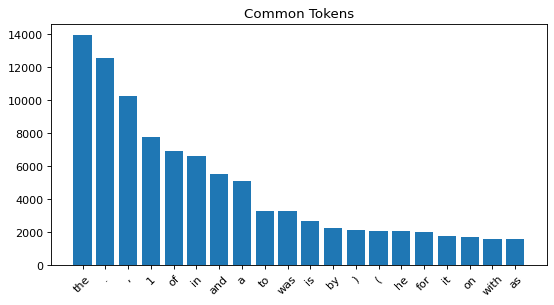

In [52]:
plot_freq(freq_most_common_tokens(train_sentences), title="Common Tokens")

As we can see the dataset is very unbalanced.

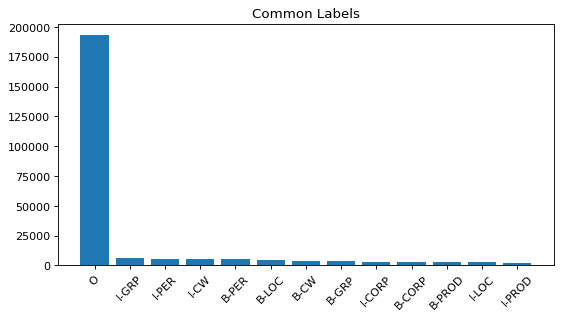

In [216]:
labels_freq = freq_most_common_tokens(train_labels, n=-1)

plot_freq(labels_freq, title="Common Labels")

In [217]:
compact = {
    'O': labels_freq['O'],
    'PER': labels_freq['B-PER'] + labels_freq['I-PER'],
    'GRP': labels_freq['B-GRP'] + labels_freq['I-GRP'],
    'CW': labels_freq['B-CW'] + labels_freq['I-CW'],    
    'LOC': labels_freq['B-LOC'] + labels_freq['I-LOC'],
    'CORP': labels_freq['B-CORP'] + labels_freq['I-CORP'],
    'PROD': labels_freq['B-PROD'] + labels_freq['I-PROD'],
}
compact

{'O': 192841,
 'PER': 10895,
 'GRP': 9459,
 'CW': 9267,
 'LOC': 7154,
 'CORP': 5962,
 'PROD': 4480}

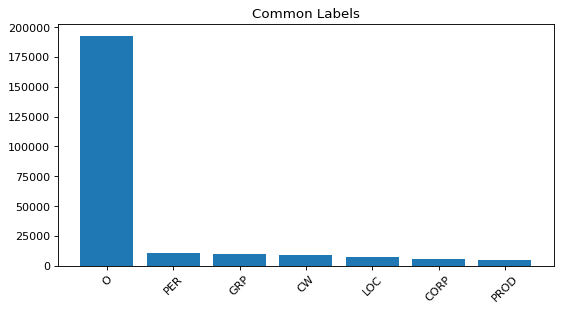

In [56]:
plot_freq(compact, title="Common Labels")

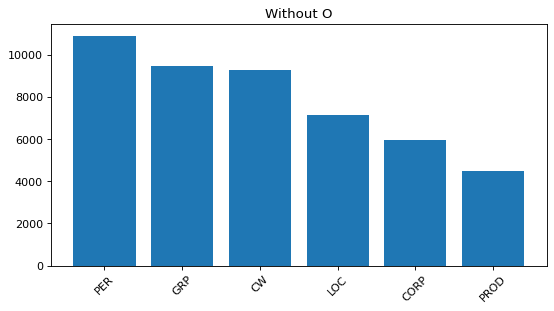

In [57]:
del compact['O']

plot_freq(compact, title="Without O")

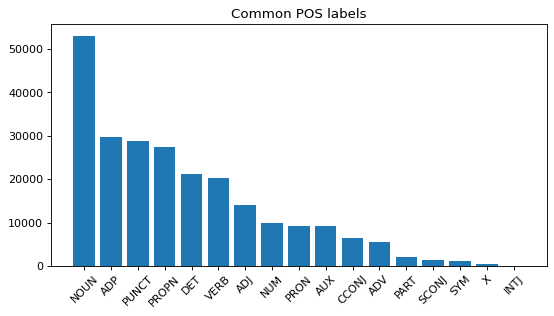

In [58]:
plot_freq(freq_most_common_tokens(train_pos), title="Common POS labels")

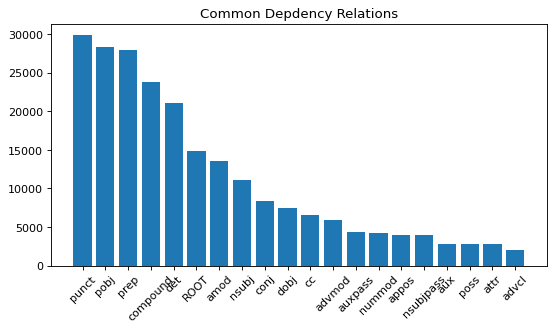

In [59]:
plot_freq(freq_most_common_tokens(train_dep), title="Common Depdency Relations")

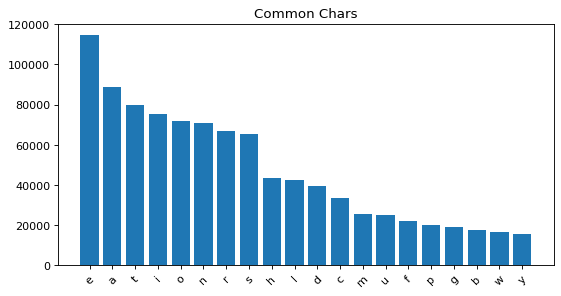

In [61]:
train_chars = ([c for word in flat_list(train_sentences) for c in word])

plot_freq(freq_most_common_tokens(train_chars), title="Common Chars")

In order to decide the vocabulary size, I wanted to see the words frequencies and also to inspect the possible words that the vocabulary may include.

In [16]:
def find_size_vocab(freq: dict, from_frequency: int, to_frequency: int):
    """
    Returns
    -------
        Prints words which have a frequency in the range [from_frequency, to_frequency],
        in the form (index, word, frequency), where 'index' is the position of that 
        word in the dictionary.
    """
    assert from_frequency <= to_frequency, "from_frequency must be smaller than to_frequency" 
    
    print("Index Word Frequency")
    for idx, (word, frequency) in enumerate(freq.items()):
        if frequency >= from_frequency and frequency <= to_frequency:
            print(idx, word, frequency)

In [133]:
freq_dep = freq_most_common_tokens(train_dep, n=-1)

In [21]:
freq = freq_most_common_tokens(train_sentences, n=-1)

In [22]:
len(freq)

27962

In [ ]:
# find_size_vocab(freq, 1, 2)

In [68]:
char_freq = freq_most_common_tokens(train_chars, n=-1)

In [67]:
len(char_freq)

51

In [70]:
# sorted(freq.items(), key=lambda t: t[::-1], reverse=True)

In [71]:
# sorted(char_freq.items(), key= lambda  x: (x[0],x[1]), reverse=False)

In [ ]:
find_size_vocab(char_freq, 1, 4)

In [135]:
def build_vocab(dataset: List[List[str]], vocab_size: int, unk_token: str, pad_token: str = None) -> dict:
    """
    Returns
    -------
        Dictionary where at each token is associated a unique integer.

    Parameters
    ----------
    dataset: List[List[str]]
        A list of lists of strings. 
        In this case each nested list is a sentence.
    
    vocab_size: int
        Dimension of the vocabolary. 
        
        If we get in input also the padding token, 
        only the first (vocab_size - 2) most common
        tokens are considered to build the vocabulary.
        
        If we have only the unknown token,
        only the first (vocab_size - 1) most common
        tokens are considered to build the vocabulary, as the 'unk_token' is 
        associated to the last position.

    unk_token: str
        String which identifies the out-of-vocabulary tokens.
        
    pad_token: str
        String which identifies the padding token.
    """
    # If padding:
    if pad_token != None:
        vocab = {key: idx+2 for idx, key in enumerate(freq_most_common_tokens(dataset, n=vocab_size-2))}
        vocab[pad_token] = 0 # The padding token is associated to the first position
        vocab[unk_token] = 1 # The unknown token is associated to the second position
    
    else: # No padding
        vocab = {key: idx for idx, key in enumerate(freq_most_common_tokens(dataset, n=vocab_size-2))}
        vocab[unk_token] = vocab_size - 1 # The token is associated to the last position
   
    
    return vocab

In [136]:
vocab_size = 20_000

pad_token = "<PAD>"
unk_token = "<UNK>"

In [30]:
vocab = build_vocab(train_sentences, vocab_size, unk_token, pad_token)

In [43]:
char_vocab = build_vocab(train_chars, 100, unk_token, pad_token)

In [139]:
dep_vocab_size = 45+2

dep_vocab =  build_vocab(train_dep, dep_vocab_size, unk_token, pad_token)

In [141]:
def write_vocab(path: str, vocab: dict):
    """
    Returns
    -------
        Writes the input dictionary in a file.
        
    Parameters
    ----------
    path: str
        Data path where to write the dictionary.
    
    vocab: dict
        A dictionary that maps tokens to integers.
    """
    with open(path, 'w', newline="", encoding='utf-8') as f:
        tsv_writer = csv.writer(f, delimiter='\t')

        for key, value in vocab.items():
            tsv_writer.writerow([key, value])

In [14]:
vocab_path = "../../data/vocab.tsv"

```Python
write_vocab(vocab_path, vocab)
```

In [143]:
dep_vocab_path = "../../data/dep_vocab.tsv"

```Python
write_vocab(dep_vocab_path, dep_vocab)
```

In [26]:
char_vocab_path = "../../data/char_vocab.tsv"

```Python
write_vocab(char_vocab_path, char_vocab)
```

In [24]:
def read_vocab(path: str) -> dict:
    """
    Returns
    -------
        A dictionary that maps tokens to integers.
        
    Parameters
    ----------
    path: str
        Data path of the dictionary.
    """
    vocab = {}
    with open(path, 'r', newline="", encoding='utf-8') as f:
        for line in f:
            line = line.strip().split('\t')
            vocab[line[0]] = int(line[1])
    return vocab

In [16]:
vocab = read_vocab(vocab_path)

In [149]:
dep_vocab = read_vocab(dep_vocab_path)

In [27]:
char_vocab = read_vocab(char_vocab_path)

In [76]:
def assign_unique_idx(labels_list: List[List[str]], pad_token: str) -> (dict, dict):
    """
    Returns
    -------
        Two dictionaries. The first one is a map
        from labels to integers; the second one
        is the reversed map.
        
    Parameters
    ----------
    labels_list: List[List[str]]
        A list of lists of strings. 
        In this case each nested list is a sentence,
        containing labels.
        
    pad_token: str
         String which identifies the padding token.
    """
    labels = freq_most_common_tokens(labels_list, n=-1)
    lab2idx = {label: idx+1 for idx, label in enumerate(labels)}
    lab2idx[pad_token] = 0 # The padding token is associated to the first position
    idx2lab = {idx: label for label, idx in lab2idx.items()} 
    
    return lab2idx, idx2lab

In [77]:
pad_token = "<PAD>"

In [82]:
# Target labels
lab2idx, idx2lab = assign_unique_idx(train_labels, pad_token)

In [20]:
lab2idx_path = "../../data/lab2idx.tsv"

```Python
write_vocab(lab2idx_path, lab2idx)
```

In [80]:
# POS labels
pos2idx, pos2lab = assign_unique_idx(train_pos, pad_token)

In [81]:
pos2idx_path = "../../data/pos2idx.tsv"

```Python
write_vocab(pos2idx_path, pos2idx)
```

# 3. Word Embedding

In this section I load the three types of pretrained embeddings I am going to use: 
- [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html)
- [GloVe](https://nlp.stanford.edu/projects/glove/)
- [FastText](https://fasttext.cc/)

In [ ]:
# ! pip install gensim==4.1.2

In [54]:
from gensim.models import *
from gensim.models.word2vec import *

In [ ]:
mode_path = "/content/drive/MyDrive/Colab Notebooks/NLP/nlp2022-hw1/model/GoogleNews-vectors-negative300.bin"

In [55]:
mode_path = "../../model/pretrained/GoogleNews-vectors-negative300.bin"

In [56]:
w2v_emb = KeyedVectors.load_word2vec_format(mode_path, binary=True)

In [68]:
w2v_pretrained_vocab = w2v_emb.key_to_index 

In [59]:
# model_w2v.most_similar('student')

In [61]:
def load_pretrained_embed(vocab: dict , word_emb, vocab_size: int, emb_dim: int) -> torch.Tensor:
    """
    Returns
    -------
        A tensor containing the embeddings
        of the tokens in 'vocab'.
        
    Parameters
    ----------
    vocab: dict
        A dictionary that maps tokens to integers.
    
    word_emb: gensim object or dict
        A data structure containing a map from 
        tokens to vectors representing the token's embeddings.
        
    vocab_size: int
        Dimension of the vocabolary.
        
    emb_dim: int
        Dimension of the embeddings.  
    """
    # The unk token will be associated with a random tensor
    pretrained_embed = torch.rand(vocab_size, emb_dim, dtype=torch.float32)
    present = 0

    for token, idx in vocab.items():
        # If the token is present in the embedding dictionary
        if token in word_emb:
            present += 1
            embedding = torch.tensor(word_emb[token], dtype=torch.float32)

            pretrained_embed[idx] = embedding

    pretrained_embed[vocab[pad_token]] = torch.zeros(emb_dim)

    print(f"Number of tokens which have not a pretrained embedding: " \
          f"{vocab_size - present}")
    return pretrained_embed

In [62]:
w2v_pretrained_embeddings = load_pretrained_embed(vocab, w2v_emb, len(vocab), 300)

Number of tokens which have not a pretrained embedding: 10383


In [63]:
pretrained_w2v_path = "/content/drive/MyDrive/Colab Notebooks/NLP/nlp2022-hw1/model/pretrained/load_embeddings/pre_w2v.pth"

In [64]:
pretrained_w2v_path = "../../model/pretrained/load_embeddings/pre_w2v.pth"

```Python
torch.save(w2v_pretrained_embeddings, pretrained_w2v_path)
```

In [ ]:
w2v_pretrained_embeddings = torch.load(pretrained_w2v_path)

In [83]:
w2v_pretrained_embeddings.shape

In [69]:
not_in = []
for token in vocab:
    if token not in w2v_pretrained_vocab:
        not_in.append(token)

By analyzing the `not_in` list I see that the pretrained corpus used to train the embeddings is much cleaner than my dataset, and excludes also many types of punctuation. Moreover, by few tests than on the training and evaluation part I noticed that **Word2Vec** does not perform well as **GloVe** and **FastText**. Therefore, I decided not to use **Word2Vec** as embeddings.

## GloVe

In [39]:
glove_file = "../../model/pretrained/glove.6B.100d.txt"

In [40]:
def load_glove_vectors(glove_file: str) -> dict:
    """
    Returns
    -------
        The glove word vectors as a dictionary.
        
    Parameters
    ----------
    glove_file: str
        Data path to the embeddings.
    
    """
    word_emb = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            split = line.split()
            
            word_emb[split[0]] = np.array(split[1:], dtype=np.float32)
    return word_emb

In [41]:
glove_emb = load_glove_vectors(glove_file)

In [78]:
glove_pretrained_vocab = list(glove_emb.keys())

In [43]:
glove_pretrained_embeddings = load_pretrained_embed(vocab, glove_emb, len(vocab), 100)

Number of tokens which have not a pretrained embedding: 1580


In [ ]:
pretrained_glove_path = "/content/drive/MyDrive/Colab Notebooks/NLP/nlp2022-hw1/model/pretrained/load_embeddings/pre_glove.pth"

In [157]:
pretrained_glove_path = "../../model/pretrained/load_embeddings/pre_glove_new_less.pth"

```Python
torch.save(glove_pretrained_embeddings, pretrained_glove_path)
```

In [159]:
glove_pretrained_embeddings = torch.load(pretrained_glove_path)

In [160]:
glove_pretrained_embeddings.shape

torch.Size([20000, 100])

In [83]:
not_in = []
for token in vocab:
    if token not in glove_pretrained_vocab:
        not_in.append(token)

In [90]:
"you've" in glove_pretrained_vocab

False

In [93]:
len(not_in)

2841

In [96]:
train_clean_path

'../../data/train_clean_new.tsv'

In [97]:
train_cleaned = read_data_like(train_clean_path)

In [108]:
lables_not_in = []

for idx, sentence in train_cleaned.items():
    for token, label in sentence:
        if token in not_in:
            lables_not_in.append((idx, token, label))
        

In [119]:
indices, tokens, labels = list(zip(*lables_not_in))

In [ ]:
Counter(labels).most_common()

In [109]:
lables_not_in

[(0, 'bolesawiec', 'B-LOC'),
 (0, 'wrocaw', 'B-LOC'),
 (12, 'yokomo', 'B-CORP'),
 (17, 'menneske', 'O'),
 (19, 'foggini', 'I-PER'),
 (25, 'tokitaka', 'O'),
 (40, 'fly-whisk', 'B-PROD'),
 (40, 'thamyi', 'O'),
 (45, 'flakne', 'I-PER'),
 (49, 'if....', 'B-CW'),
 (55, 'scrubb', 'I-PER'),
 (59, 'ayen', 'O'),
 (59, 'objat', 'B-LOC'),
 (65, 'pelit', 'B-CW'),
 (66, 'rxpressen', 'O'),
 (66, 'rxpressen', 'O'),
 (66, 'marstal', 'B-LOC'),
 (66, 'rudkbing', 'B-LOC'),
 (92, 'httrack', 'B-CW'),
 (102, 'under-1', 'I-GRP'),
 (107, 'terebovlia', 'I-LOC'),
 (119, 'bambusoideae', 'B-PROD'),
 (120, 'm.u.d.', 'B-CW'),
 (122, "lloyd's", 'B-CORP'),
 (123, 'walkham', 'I-LOC'),
 (126, 'pamies', 'I-PER'),
 (132, '1th', 'O'),
 (143, 'siljestrom', 'I-PER'),
 (145, 'charmanwati', 'O'),
 (145, 'charmanvati', 'O'),
 (151, '1th', 'O'),
 (151, '1nd', 'O'),
 (159, 'adimali', 'O'),
 (163, 'tru1', 'B-CW'),
 (165, 'scheifele', 'O'),
 (167, 'u.s.a.a.f.', 'B-CW'),
 (178, 'wait...', 'I-CW'),
 (178, "don't", 'I-CW'),
 (184, 'k

## Fastext

In [46]:
from gensim.models import fasttext

In [47]:
fastext_path = "/content/drive/MyDrive/Colab Notebooks/NLP/nlp2022-hw1/model/pretrained/fastext300.bin"

In [48]:
fastext_path = "../../model/pretrained/fastext300.bin"

In [49]:
fast_emb = fasttext.load_facebook_vectors(fastext_path, encoding='utf-8')

In [37]:
fast_pretrained_vocab = fast_emb.key_to_index 

In [51]:
fast_pretrained_embeddings = load_pretrained_embed(vocab, fast_emb, len(vocab), 300)

Number of tokens which have not a pretrained embedding: 0


In [33]:
pretrained_fast_path = "/content/drive/MyDrive/Colab Notebooks/NLP/nlp2022-hw1/model/pretrained/load_embeddings/pre_fast.pth"

In [52]:
pretrained_fast_path = "../../model/pretrained/load_embeddings/pre_fast_new_less.pth"

In [53]:
torch.save(fast_pretrained_embeddings, pretrained_fast_path)

In [33]:
fast_pretrained_embeddings = torch.load(pretrained_fast_path)

In [34]:
fast_pretrained_embeddings.shape

torch.Size([11200, 300])

In [45]:
not_in = []
for token in vocab:
    if token not in fast_pretrained_vocab:
        not_in.append(token)

In [48]:
not_in

['_',
 "people's",
 "women's",
 'laliga',
 'breuning',
 'bambusoideae',
 'meyrick',
 "mcdonald's",
 'wrocaw',
 'presov',
 '1k1',
 "lloyd's",
 'odz',
 "king's",
 'biaystok',
 'aydn',
 'valladolid',
 'olof',
 'a.f.c.',
 'koninklijke',
 'logano',
 'alstom',
 'melodifestivalen',
 "o'brien",
 'sveriges',
 'olsztyn',
 'niigata',
 'bochum',
 'plzen',
 '1do',
 "hudson's",
 "harper's",
 'hampson',
 'jean-claude',
 'fieldturf',
 "ain't",
 'kristiansand',
 'yaroslavl',
 'jozef',
 'sanremo',
 'rietveld',
 'waltman',
 'kodansha',
 'kaiserslautern',
 'costanzo',
 'cherkasy',
 'abitur',
 'auteuil',
 'insensatez',
 'jobim',
 'vidin',
 'televisao',
 'kielce',
 "assassin's",
 'nakajima',
 'coulthard',
 'comoros',
 'siedlce',
 'otello',
 'sense1',
 'rzeszow',
 'mersin',
 'knopfler',
 'balliol',
 'gottingen',
 "sainsbury's",
 'kalmar',
 'televisa',
 'kiryat',
 'bilecik',
 'enserio',
 'a&m',
 'aurivillius',
 'vilhelm',
 'jingwei',
 'cooder',
 "bishop's",
 'katanga',
 'r.s.c.',
 'anderlecht',
 'jean-baptist

# 4. Further Analysis

In this section I want to inspect more the data in order to understand, if possible, the relation between tokens and labels and their "context".

In [ ]:
def read_dataset(data_path: str) -> (List[List[str]], List[List[str]]):
    """
    Returns
    -------
        Two lists of lists containing sentences and labels respectively.
        
    Parameters
    ----------
    data_path: str
        Data path of the dataset.
    """
    
    sentences_list = []
    labels_list = []
    
    with open(data_path, "r", encoding='utf-8') as f:
        for line in f:
            row = line.strip()
            
            if row.startswith("#\tid"): # New sentence
                sentence = []
                labels = []
                
            elif row == "": # End of the sentence
                sentences_list.append(sentence)
                labels_list.append(labels)
            
            else: # Words of a sentence
                word, label = row.split('\t')
                
                sentence.append(word)
                labels.append(label)
   
    return sentences_list, labels_list

In [120]:
# Create a dictionary which is like the data file
def read_data_like(data_path: str) -> dict:
    """
    Returns
    -------
        A dictionaty that "mimic" the file structure
        of the dataset.
        So, the keys of the dictionary are the sentence id;
        Each element of the dictionary is a list contaning
        pairs of tokens and labels.
        
    Parameters
    ----------
    data_path: str
        Data path of the dataset.
    """
    data = {}

    with open(data_path, "r") as f:
        for line in f:
            row = line.strip()

            if row.startswith("#\tid"): # New sentence
                sentence_id = int(row.split('\t')[-1])
                data[sentence_id] = []
        
            elif row == "": # End of the sentence
                continue
                
            else: # Words of a sentence
                word, label = row.split('\t')
                data[sentence_id].append((word, label))
    
    return data

In [121]:
train_like_file = read_data_like(train_clean_path)

In [125]:
train_like_file[0]

[('it', 'O'),
 ('lies', 'O'),
 ('approximately', 'O'),
 ('north', 'O'),
 ('east', 'O'),
 ('of', 'O'),
 ('bolesawiec', 'B-LOC'),
 (',', 'O'),
 ('and', 'O'),
 ('west', 'O'),
 ('of', 'O'),
 ('the', 'O'),
 ('regional', 'O'),
 ('capital', 'O'),
 ('wrocaw', 'B-LOC'),
 ('.', 'O')]

In [134]:
def get_tokens_labels_before(ds: dict, before_label:str) -> list:
    """
    Returns
    -------
        A list with the tokens and the corresponding label
        preceding the tokens whose label is 'before_label'.
        
        The list is composed by tuples (idx, position, token, label) where:
        - idx is the sentence id
        - postion of the token in the sentence
        - token
        - label
    """
    
    before_list = []

    for idx, sentence in ds.items():
        for position, (token, label) in enumerate(sentence):
            if before_label in label:
                before_list.append((idx, position, sentence[position - 1][0], sentence[position - 1][1]))
    
    return before_list

In [163]:
b_labels = ["B-PER", "B-LOC", "B-GRP", "B-CORP", "B-CW", "B-PROD"]
i_labels = ["I-PER", "I-LOC", "I-GRP", "I-CORP", "I-CW", "I-PROD"]

In [164]:
before_entity = {}


for lab in b_labels:
    before_entity[lab] = get_tokens_labels_before(train_like_file, lab)

In [166]:
common_before = {}
for lab in b_labels:
    _, _, common_before[lab], _ = list(zip(*before_entity[lab]))
    

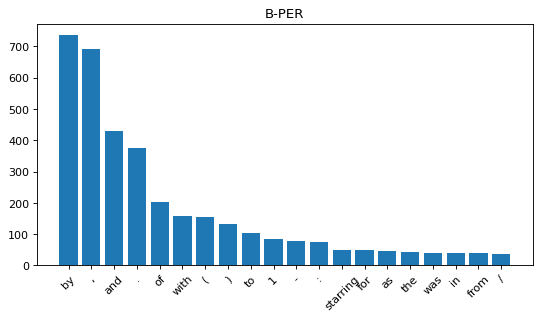

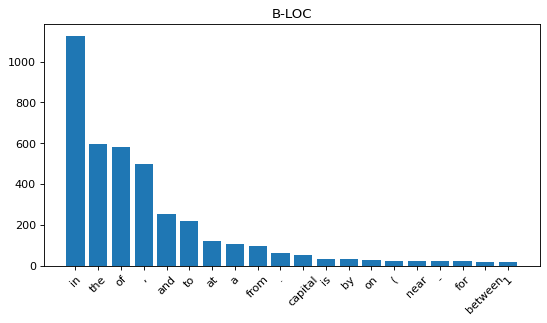

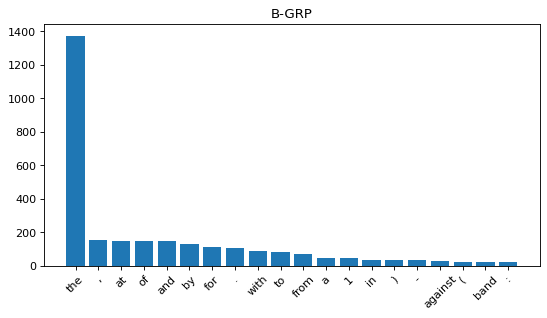

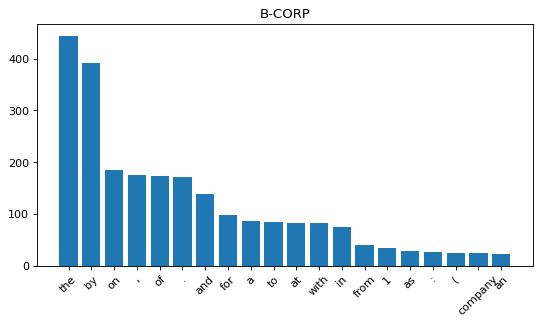

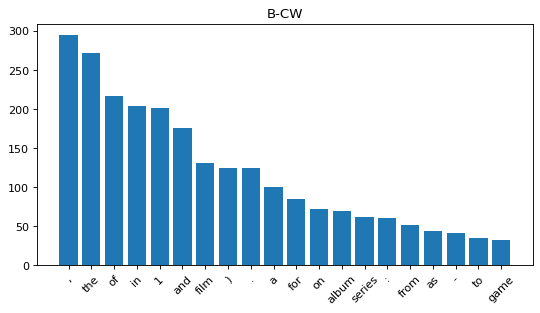

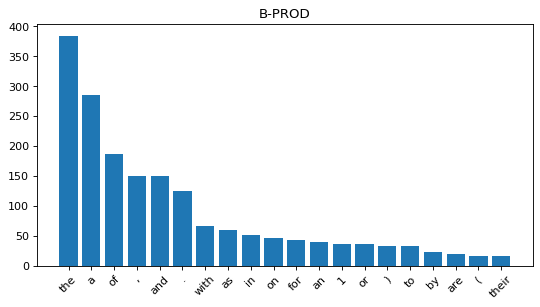

In [167]:
for lab in b_labels:
    freq = dict(Counter(common_before[lab]).most_common(n=20))
    plot_freq(freq, title=lab)

Most of the preceding tokens are stopwords or punctuation

In [156]:
def get_tokens_labels(ds: dict, entity_label:str) -> list:
    """
    Returns
    -------
        A list with the tokens and the corresponding label,
        where the label is 'entity_label'.
        
        The list is composed by tuples (idx, position, token, label) where:
        - idx is the sentence id
        - postion of the token in the sentence
        - token
        - label
    """
    
    entities_list = []

    for idx, sentence in ds.items():
        for position, (token, label) in enumerate(sentence):
            if entity_label in label:
                entities_list.append((idx, position, sentence[position][0], sentence[position][1]))
    
    return entities_list

In [171]:
b_entities = {}

for lab in b_labels:
    b_entities[lab] = get_tokens_labels(train_like_file, lab)

In [174]:
b_common = {}
for lab in b_labels:
    _, _, b_common[lab], _ = list(zip(*b_entities[lab]))

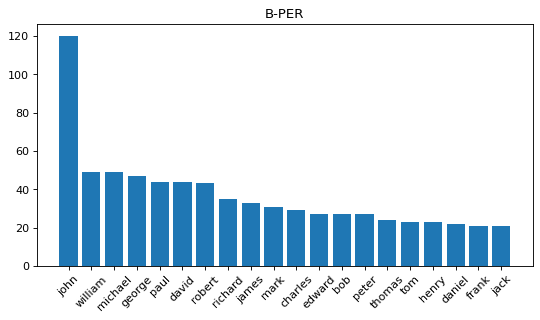

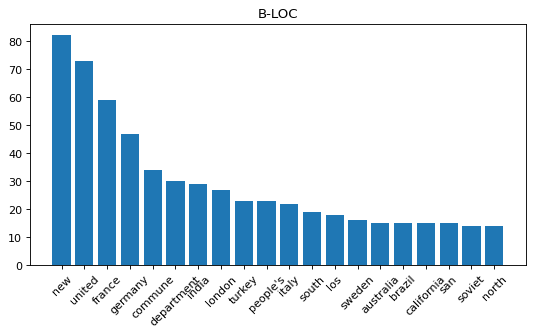

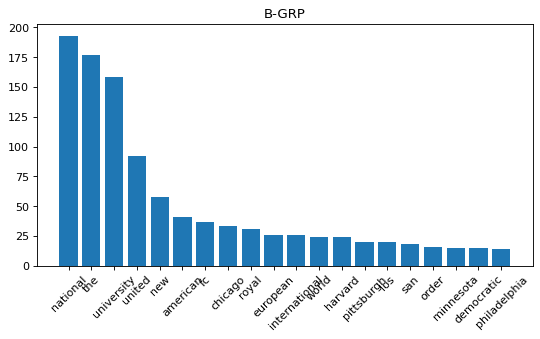

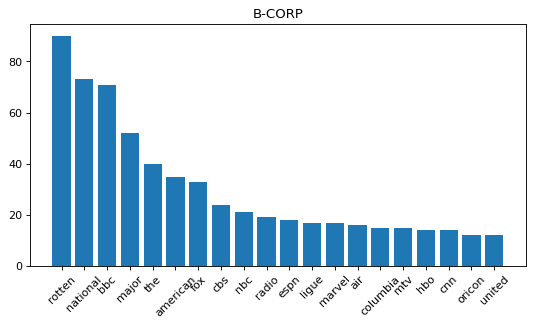

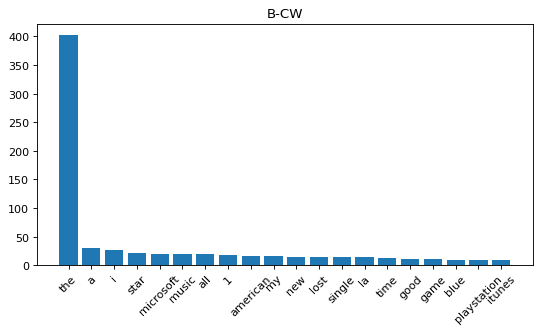

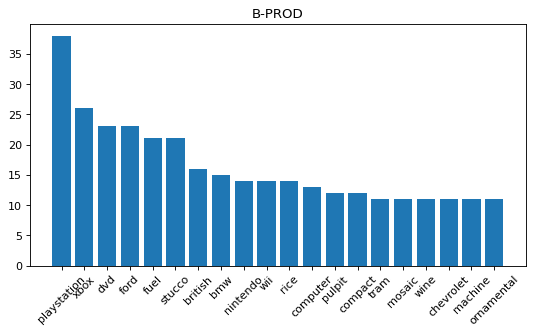

In [175]:
for lab in b_labels:
    freq = dict(Counter(b_common[lab]).most_common(n=20))
    plot_freq(freq, title=lab)

These plots explain very well the principal problem of my classifier. If you inspect the confusion matrix of my model (in the **training** notebook), you can see that the most two mis-classified labels are `B-PROD` and `B-CW`. In particular, the errors come from the fact that the model classify them as `O`. 

In these plots, we can see that `B-PROD` and `B-CW` are frequently either rare words or even stopwords, as happens for `CW`. So, the model easily confuse them with `O`. Maybe, for `B-PROD` is sufficient to increase the number of samples.

I thought that a possible solution is to concatenate the POS tag to the word embeddings, however I did not find a good tuning for the hyper-parameters.

Perhaps, another semantic or morphological approach could have helped.

In [184]:
i_entities = {}

for lab in i_labels:
    i_entities[lab] = get_tokens_labels(train_like_file, lab)

In [185]:
i_common = {}
for lab in i_labels:
    _, _, i_common[lab], _ = list(zip(*i_entities[lab]))

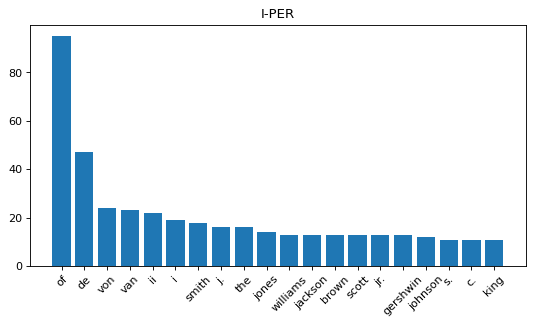

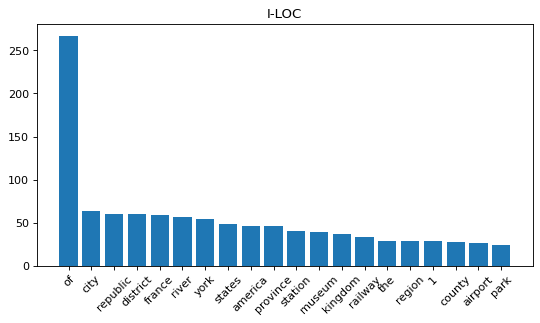

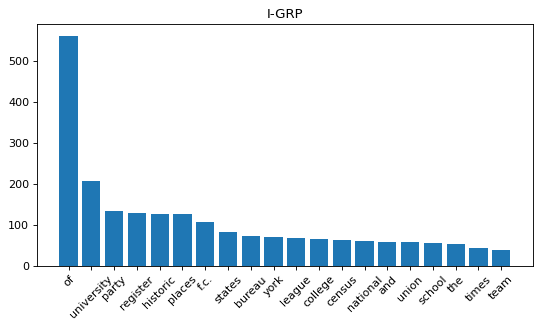

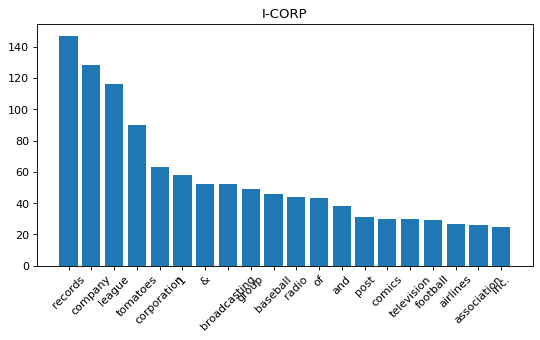

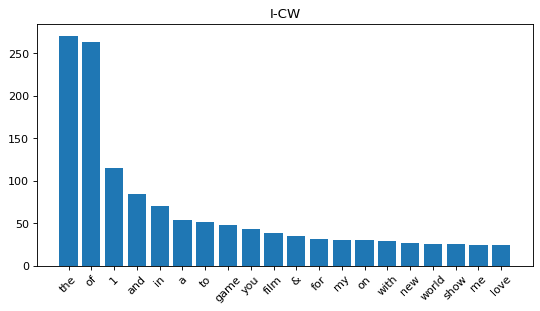

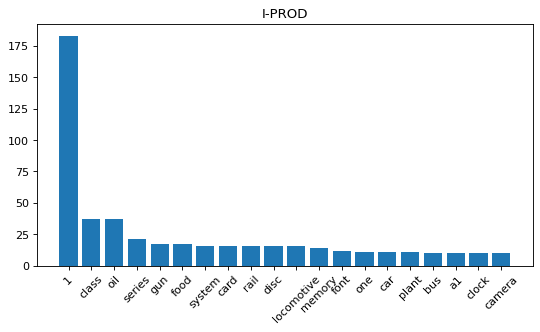

In [186]:
for lab in i_labels:
    freq = dict(Counter(i_common[lab]).most_common(n=20))
    plot_freq(freq, title=lab)

Here there is a rough analysis on the sentences lengths in order to see the expected sentence length for different batch sizes. 
From this, I choose to use `collate_batch` in the **training** notebook, in order not to pad the sentences to the maximum length (41), but to the maximum length in the batch.

The idea and function `plot_expected_lengths` come from here: https://www.kaggle.com/code/bminixhofer/speed-up-your-rnn-with-sequence-bucketing/notebook

In [201]:
lengths = np.array([len(s) for s in train_sentences])

In [12]:
def print_lengths(from_len, to_len):
    print(f"Sentences with length between {from_len + 1} and {to_len - 1}: " \
        f"{len(lengths[lengths < to_len]) - len(lengths[lengths < from_len])}" )

In [13]:
print(f"Sentences with length less than 10: {len(lengths[lengths < 10])}" )

Sentences with length less than 10: 1900


In [14]:
# print(f"Sentences with length between 11 and 19: {len(lengths[lengths < 20]) - len(lengths[lengths < 10])}" )
print_lengths(10, 20)

Sentences with length between 11 and 19: 8264


In [15]:
print_lengths(10, 15)

Sentences with length between 11 and 14: 4381


In [16]:
print_lengths(15, 20)

Sentences with length between 16 and 19: 3883


In [21]:
print_lengths(20, 30)

Sentences with length between 21 and 29: 3912


In [22]:
print_lengths(30, 40)

Sentences with length between 31 and 39: 457


In [23]:
print_lengths(40, 50)

Sentences with length between 41 and 49: 2


In [25]:
print(f"Sentences with length greater than 41: {len(lengths[lengths == 41])}")

Sentences with length greater than 41: 1


In [197]:
import tqdm
import math
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import seaborn as sns
MAX_LEN = 41

In [198]:
def plot_expected_lengths(lengths, batch_sizes, choose_length, markers=[], n_batches=10000):
    fig, axarr = plt.subplots(len(batch_sizes), 1, figsize=(14, 20), sharex=True)
    expected_lengths = {}
    
    for i, batch_size in enumerate(batch_sizes):
        maxs = []

        for _ in range(n_batches):
            val = choose_length(np.random.choice(lengths, batch_size))
            maxs.append(math.ceil(val))

        pd.Series(maxs).plot.hist(bins=50, ax=axarr[i], density=True, color='black', edgecolor='white', alpha=0.1)
        expected = np.mean(maxs)
        expected_lengths[batch_size] = expected
        
        max_y = axarr[i].get_ylim()[1]
        
        axarr[i].vlines([expected], 0, 1e3, 'limegreen', lw=4)
        axarr[i].set_ylim([0, max_y])
        axarr[i].set_xlim([0, max(lengths)])
        axarr[i].set_ylabel(f'batch_size={batch_size}', rotation=0)
        axarr[i].yaxis.set_label_coords(-0.1, 0.45)
        axarr[i].set_yticks([])

    for marker in markers:
        con = ConnectionPatch(xyA=(marker, axarr[0].get_ylim()[1]), xyB=(marker, 0), coordsA='data', 
                              coordsB='data', axesA=axarr[0], axesB=axarr[-1], color='red', lw=4)
        axarr[0].add_artist(con)
    
    axarr[0].set_zorder(1)
    axarr[0].set_title(f'Expected sequence lengths with various batch sizes (n per batch = {n_batches})')
    plt.subplots_adjust(hspace=0)
    
    return expected_lengths

In [199]:
batch_sizes = [32, 64, 128, 256, 512]

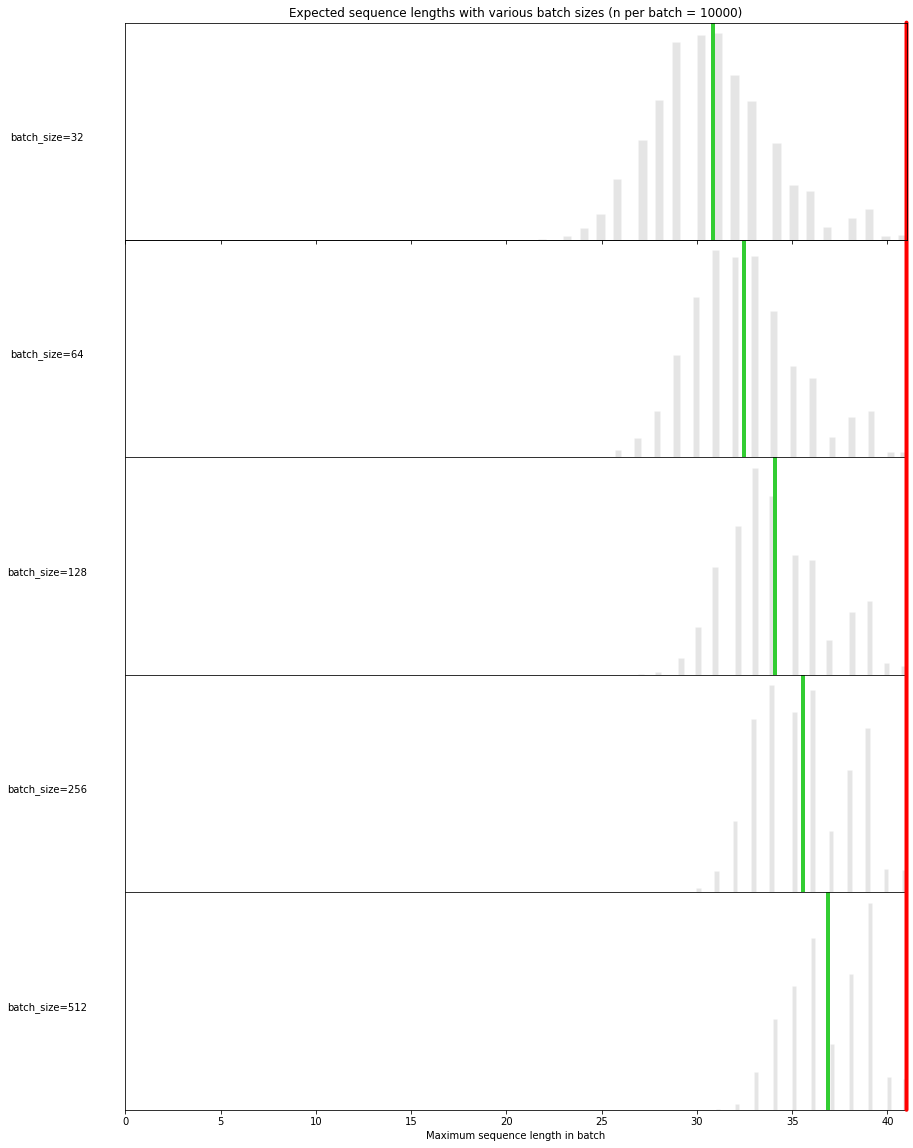

In [202]:
expected_lengths = plot_expected_lengths(lengths, batch_sizes, lambda lengths: lengths.max(), markers=[MAX_LEN])
plt.xlabel('Maximum sequence length in batch')
print()

Text(0.5, 0, '95th percentile of sequence length in batch')

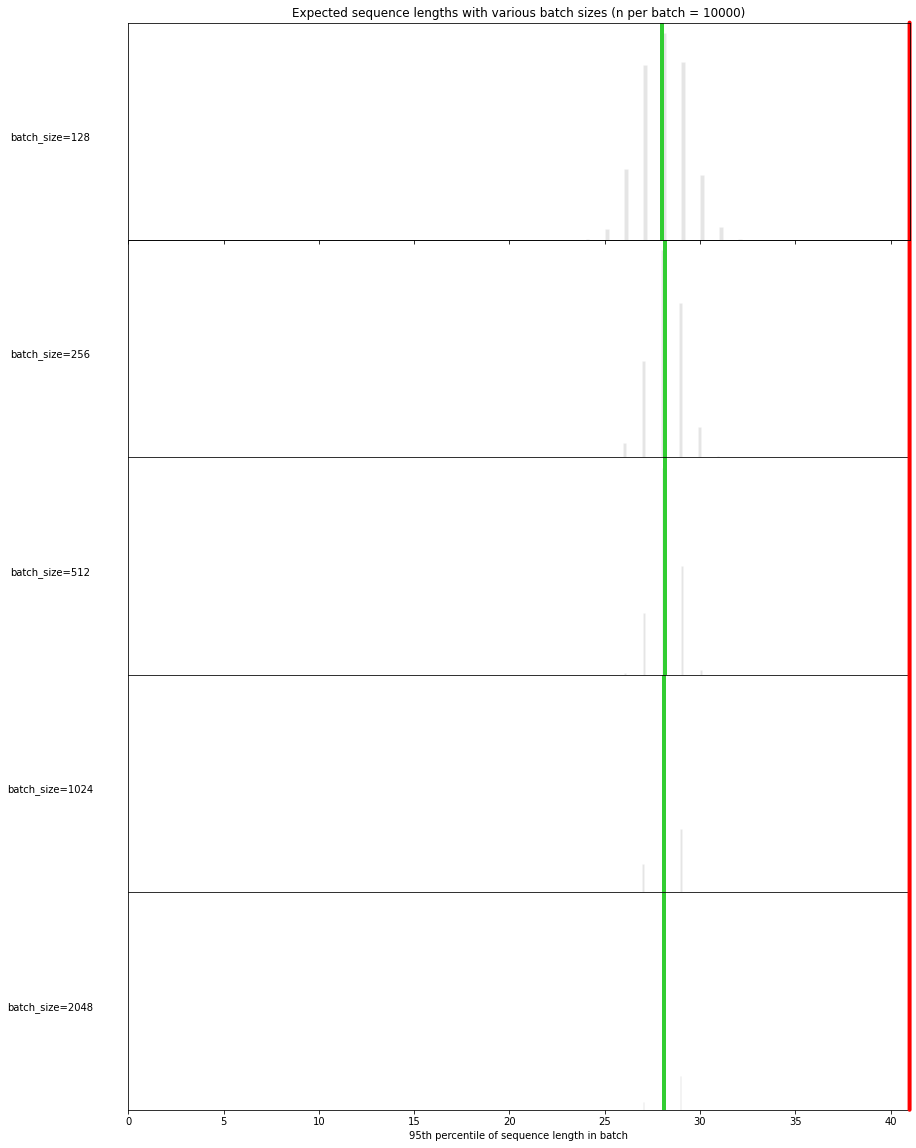

In [ ]:
expected_lengths = plot_expected_lengths(lengths, batch_sizes, lambda lengths: np.percentile(lengths, q=95), markers=[MAX_LEN])
plt.xlabel('95th percentile of sequence length in batch')

In [ ]:
np.percentile(lengths, q=95)

28.0